In [1]:
import pandas as pd
from textblob import TextBlob
import matplotlib.pyplot as plt

In [15]:
def busca(df, *words):
    
    return df[np.logical_xor.reduce([df['Content'].str.contains(word) for word in words])]

In [37]:
news = pd.read_pickle('noticias.pkl')

news['Date'] = pd.to_datetime(news['Date'])
news=news.loc[(news['Date']> '2018-12-31') & (news['Date']< '2020-08-19')]
news = busca(news, 'bitcoin', 'Bitcoin')

In [38]:
news['weight'] = news['Views']/news.groupby('Date')['Views'].transform('sum')
news['value']=news['TBPolarity']*news['weight']

In [70]:
preço_btc = pd.read_csv('btcusd.csv', skiprows=1).sort_values(by='Date')

preço2019 = preço_btc[(pd.to_datetime(preço_btc['Date']).dt.year >= 2019)]
preço2019['Date']=pd.to_datetime(preço2019['Date'])

C:\Users\dwsur\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [3]:
import numpy as np

In [4]:
def newscorr(dado1, dado2):                                          #função que avalia o melhor número de dias de lag
    dummy=0                                                         #através da correlação entre os dados extraídos e os dados do btc
    max = 0                                                         #dado 1 começa a partir da i+1-ésima, logo é o dado que queremos prever
    for i in range(15):
        if i == 7:
            print("Lag de maior correlação:", max, " dias atrás")
            return 
        k=i+1
        h=i-7
        if i==0:
            print("Correlação com notícias do dia anterior:", np.corrcoef(dado1[k:h].astype('float64'), dado2[:-8].astype('float64'))[0][1])
        else:
            print("Correlação com notícias de ", 1+i, " dias atrás:", np.corrcoef(dado1[k:h].astype('float64'), dado2[:-8].astype('float64'))[0][1])
        if np.corrcoef(dado1[k:h].astype('float64'), dado2[:-8].astype('float64'))[0][1]>dummy:
            dummy = np.corrcoef(dado1[k:h].astype('float64'), dado2[:-8].astype('float64'))[0][1]
            max=i+1

In [84]:
newsagg = news.set_index('Date').groupby(pd.Grouper(freq='D')).sum()

idx = pd.date_range('01-01-2019', '08-17-2020')
newsagg = newsagg.reindex(idx, fill_value=0)

newsagg.reset_index(inplace=True)

In [85]:
newsagg['valor']=0

In [86]:
for i in range(np.shape(newsagg)[0]):
    if i == 12:
        newsagg.loc[i, 'valor'] = newsagg.loc[i, 'value']
    if i == 13:
        newsagg.loc[i, 'valor'] = newsagg.loc[i-1, 'value']/2
    elif i>13:
        newsagg.loc[i, 'valor'] = newsagg.loc[i, 'value'] + newsagg.loc[i-1, 'value']/2 + \
        newsagg.loc[i-2, 'value']/6 + newsagg.loc[i-3, 'value']/8 +newsagg.loc[i-4, 'value']/10 + \
        newsagg.loc[i-5, 'value']/12 + newsagg.loc[i-6, 'value']/14 + newsagg.loc[i-7, 'value']/16 + \
        newsagg.loc[i-8, 'value']/18 + newsagg.loc[i-9, 'value']/20 + newsagg.loc[i-10, 'value']/22 + \
        newsagg.loc[i-11, 'value']/24 + newsagg.loc[i-12, 'value']/26 + newsagg.loc[i-13, 'value']/28

In [87]:
newsagg.loc[newsagg["valor"] != 0].mean()

C:\Users\dwsur\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  """Entry point for launching an IPython kernel.


Views             12469.337232
TBPolarity            0.048473
TBSubjectivity        0.299375
weight                0.557505
value                 0.037410
valor                 0.088258
dtype: float64

In [96]:
newsagg.loc[newsagg["valor"] == 0, 'valor'] = 0.088258

In [97]:
corr = pd.merge(left=preço2019, left_on='Date',
         right=newsagg, right_on='index')

In [98]:
newscorr(corr['Close'], corr['valor'])

Correlação com notícias do dia anterior: 0.3961847999865827
Correlação com notícias de  2  dias atrás: 0.3978199821255872
Correlação com notícias de  3  dias atrás: 0.4011226117398951
Correlação com notícias de  4  dias atrás: 0.40038274688390896
Correlação com notícias de  5  dias atrás: 0.3930931192662326
Correlação com notícias de  6  dias atrás: 0.3820596355285539
Correlação com notícias de  7  dias atrás: 0.37788687578111635
Lag de maior correlação: 3  dias atrás


In [101]:
def melhorMA(btc, dado):
    max=0
    value=0
    for i in range(30):
        lagged =  dado.rolling(window=i+1).mean().dropna()
        if np.corrcoef(btc[i:].astype('float64'), lagged.astype('float64'))[0][1]>value:
            value = np.corrcoef(btc[i:].astype('float64'), lagged.astype('float64'))[0][1]
            max=i+1
        print(np.corrcoef(btc[i:].astype('float64'), lagged.astype('float64'))[0][1])
    print(max, value)
    return

In [103]:
melhorMA(corr['Close'], corr['valor'])

0.398116768803467
0.4234933545610348
0.44128032420687907
0.45404958449727917
0.46470320760140943
0.47275119385064374
0.4775704522731772
0.481313983815163
0.4843307081372272
0.48626844062525565
0.4884067320335192
0.49027375427203945
0.49171010257655406
0.4926344559817124
0.49308229468527615
0.49312099982701535
0.49213118353261737
0.49082623933816966
0.4891746396598621
0.48718357225171727
0.48472470797718675
0.4817906783041506
0.47885855472496897
0.4755575609947252
0.47179107871866394
0.46769156494041986
0.4633839149418242
0.45911829001497295
0.45487741070932836
0.4507352878850492
16 0.49312099982701535


In [142]:
def lucro(preços, decisao):
    inicio = True
    btc = 0
    primeiro = False
    caixa = 0
    investimento = 0
    valor = []
    for i in range(np.shape(preços)[0]):
        if (inicio == True) & (decisao.loc[i, 'compra'] == True):
            inicio = False
            btc = 1
            primeiro = True
            investimento = preços.loc[i+17, 'Open']
        elif (inicio == False) & (decisao.loc[i, 'venda'] == True) & (primeiro == True):
            btc = 0
            primeiro = False
            caixa = preços.loc[i+17, 'Close']
        elif (inicio == False) & (decisao.loc[i, 'compra'] == True) & (primeiro == False):
            btc = caixa/preços.loc[i+17, 'Open']
            caixa = 0
        elif (inicio == False) & (decisao.loc[i, 'venda'] == True) & (primeiro == False):
            caixa = btc*preços.loc[i+17, 'Close']
            btc = 0
        valor.append(max(caixa, btc*preços.loc[i+16, 'Close']))
    if caixa == 0:
        caixa = btc*preços.loc[i+16, 'Close']
        valor.append(max(caixa, btc*preços.loc[i+16, 'Close']))
    return valor, 100*(caixa-investimento)/investimento, pd.Series(valor).var(), caixa/investimento

In [114]:
def teste(noticias, preços):
    agregado = pd.merge(left=preços, left_on='Date',
         right=noticias, right_on='index')
    
    for i in range(7):
        medias = pd.DataFrame()

        medias['MA16']=agregado['valor'].rolling(window=16).mean().dropna()
        medias['MA4'] = agregado.loc[15-i:, 'valor'].rolling(window=i+1).mean().dropna()

        medias = medias.set_index(agregado.loc[15:, 'Date'])

        medias['posição'] = medias['MA4'] > medias['MA16']
        medias['anterior'] =  medias['posição'].shift(1)

        medias.dropna(inplace=True)

        medias['mudança'] = np.where(medias['posição'] == medias['anterior'], False, True)

        medias = medias.reset_index()

        medias['venda'] = np.where((medias['posição'] == False) & (medias['mudança'] == True), True, False)
        medias['compra'] = np.where((medias['posição'] == True) & (medias['mudança'] == True), True, False)
        
        print(lucro(agregado[16:], medias)[1], lucro(agregado[16:], medias)[2])

In [115]:
teste(newsagg, preço2019)

323.49336452920613 9246679.332873909
231.879791032121 4533511.684869946
367.47410686861906 11305045.038896184
446.4062012736712 17456743.271640666
157.34024364618648 8061391.053499199
219.88252611923664 10284768.445929904
214.80836945536979 11099461.394663785


In [146]:
medias = pd.DataFrame()

medias['MA18']=newsagg['valor'].rolling(window=16).mean().dropna()
medias['MA4'] = newsagg.loc[15:, 'valor'].rolling(window=1).mean().dropna()

medias = medias.set_index(newsagg.loc[15:, 'index'])

medias['posição'] = medias['MA4'] > medias['MA18']
medias['anterior'] =  medias['posição'].shift(1)

medias.dropna(inplace=True)

medias['mudança'] = np.where(medias['posição'] == medias['anterior'], False, True)

medias = medias.reset_index()

medias['venda'] = np.where((medias['posição'] == False) & (medias['mudança'] == True), True, False)
medias['compra'] = np.where((medias['posição'] == True) & (medias['mudança'] == True), True, False)

In [147]:
lucro(corr[16:], medias)[-3:]

(155.79808839979336, 2900687.5080049704, 2.5579808839979337)

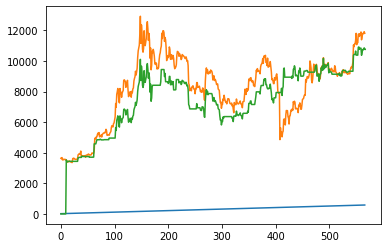

In [141]:
plt.plot(corr.loc[16:, 'Close'].reset_index())
plt.plot(lucro(corr[16:], medias)[0])
plt.show()

In [151]:
df = pd.DataFrame(lucro(corr[16:], medias)[0])

In [154]:
df.pct_change().rolling(window=3).std()*(252**0.5)

,0
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
563,0.178852
564,0.170310
565,0.068892
566,0.137054
